In [1]:
url = "https://www.multpl.com/s-p-500-dividend/table/by-year"
print(url)  # This page lists the annual dividends of the S&P 500,
            # adjusted for inflation.

https://www.multpl.com/s-p-500-dividend/table/by-year


In [2]:
import numpy as np   # Traditionally we use "np" as an alias for numpy.
import pandas as pd  # Traditionally we use "pd" as an alias for pandas.

In [3]:
# We use pandas read_html() function to read html tables into
# a list of DataFrames.
list_of_DataFrames = pd.read_html(url, header=0)
print(len(list_of_DataFrames))  # It is a list of only one DataFrame.

1


In [4]:
df = list_of_DataFrames[0]
print(type(df))
print(len(df))
df.head()

<class 'pandas.core.frame.DataFrame'>
150


,Date,Value Value
0,"Dec 31, 2020",58.28
1,"Dec 31, 2019",59.03
2,"Dec 31, 2018",55.73
3,"Dec 31, 2017",51.70
4,"Dec 31, 2016",49.31


In [5]:
df = df.set_index("Date")
df.head()

,Value Value
Date,
"Dec 31, 2020",58.28
"Dec 31, 2019",59.03
"Dec 31, 2018",55.73
"Dec 31, 2017",51.70
"Dec 31, 2016",49.31


In [6]:
df.tail()

,Value Value
Date,
"Dec 31, 1875",7.14
"Dec 31, 1874",7.47
"Dec 31, 1873",7.06
"Dec 31, 1872",6.04
"Dec 31, 1871",5.35


In [7]:
ts = df["Value Value"]
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
Dec 31, 2020    58.28
Dec 31, 2019    59.03
Dec 31, 2018    55.73
Dec 31, 2017    51.70
Dec 31, 2016    49.31
Name: Value Value, dtype: float64

(0, 61.7215)

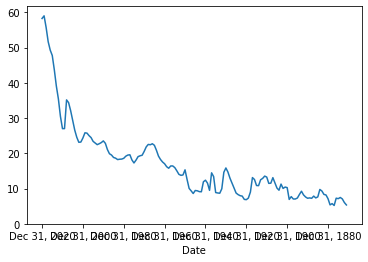

In [8]:
import matplotlib
%matplotlib inline
ts.plot().set_ylim((0,None))

This is a bit goofy.  Because our list of dividends is in reverse chronological order, our dividend plot is reversed in time!  Also the dates look strange.  What is going on?

In [9]:
ts.index

Index(['Dec 31, 2020', 'Dec 31, 2019', 'Dec 31, 2018', 'Dec 31, 2017',
       'Dec 31, 2016', 'Dec 31, 2015', 'Dec 31, 2014', 'Dec 31, 2013',
       'Dec 31, 2012', 'Dec 31, 2011',
       ...
       'Dec 31, 1880', 'Dec 31, 1879', 'Dec 31, 1878', 'Dec 31, 1877',
       'Dec 31, 1876', 'Dec 31, 1875', 'Dec 31, 1874', 'Dec 31, 1873',
       'Dec 31, 1872', 'Dec 31, 1871'],
      dtype='object', name='Date', length=150)

Aha!  We have that problem again where the dates are read in as strings rather than as dates.

In [10]:
ts.index = pd.to_datetime(ts.index)

In [11]:
ts.index

DatetimeIndex(['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31',
               '2016-12-31', '2015-12-31', '2014-12-31', '2013-12-31',
               '2012-12-31', '2011-12-31',
               ...
               '1880-12-31', '1879-12-31', '1878-12-31', '1877-12-31',
               '1876-12-31', '1875-12-31', '1874-12-31', '1873-12-31',
               '1872-12-31', '1871-12-31'],
              dtype='datetime64[ns]', name='Date', length=150, freq=None)

(0, 61.7215)

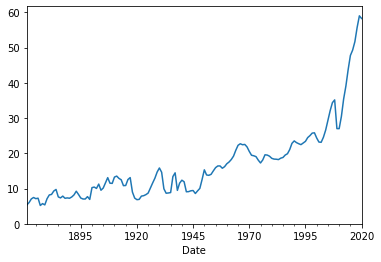

In [12]:
ts.plot().set_ylim((0,None))

This is much better.  The dates are fixed, and the plotting function corrects for the reversed chronlogical order.  But I confess that I am still nervous about having my series in reverse chronological order, so let's fix this.

In [13]:
ts = ts.sort_index()
ts.head()

Date
1871-12-31    5.35
1872-12-31    6.04
1873-12-31    7.06
1874-12-31    7.47
1875-12-31    7.14
Name: Value Value, dtype: float64

As a finance person, instintively I think of dividends as something that would compound exponentially over time, leading us to want to do a log transformation of the data.  So when exactly is a log transformation justified?  First of all, it helps if all the data values are positive, because we can't take a log of zero or negative numbers.  Second, we'd like to see the fluctuations of the series be roughly proportional to the level of the series (as opposed to independent of the level), called a ***variance stabilizing*** transformation.

A simple way to observe this is to examing the time plots of the differences of the original series as well as the log transformed one.

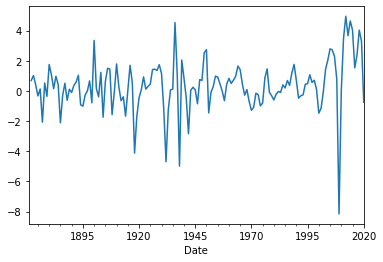

In [14]:
ts.diff().plot()

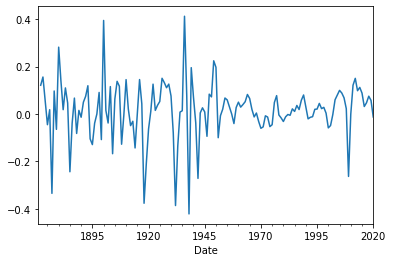

In [15]:
np.log(ts).diff().plot()

To be honest, it doesn't look like the log transformation has stabilized the variance.  It does seem like the variance of the dividends declined markedly after World War II (nonstationarity!).  But it does seem like if we consider the pre- and post-war periods separately, the log transformation does seem to stabilize variance.

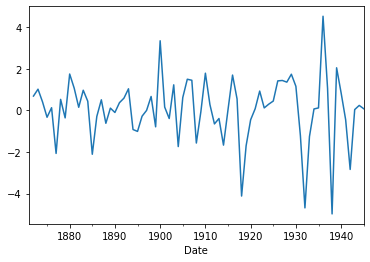

In [16]:
# pre-WW2 untransformed differences
ts[:'1945-12-31'].diff().plot()

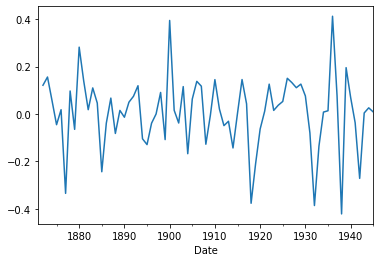

In [17]:
# pre-WW2 transformed differences has more stable variance.
np.log(ts[:'1945-12-31']).diff().plot()

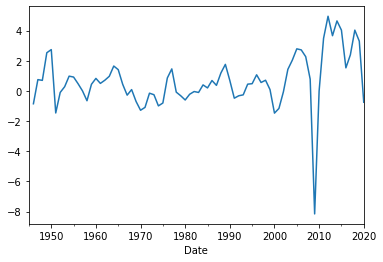

In [18]:
# post-WW2 untransformed differences
ts['1945-12-31':].diff().plot()

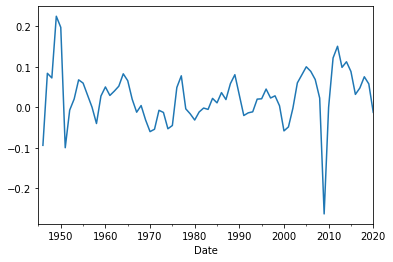

In [19]:
# post-WW2 transformed differences has more stable variance.
np.log(ts['1945-12-31':]).diff().plot()

So perhaps performing a log transformation makes sense, as long as we allow for a step change decrease in the variance after WWII.  So let's takes logs and plot the results.

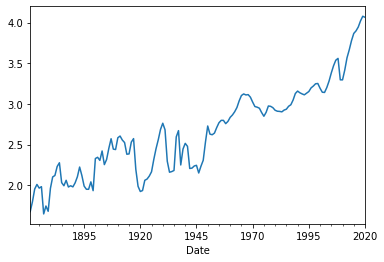

In [20]:
logdivs = np.log(ts)
logdivs.plot()

Let's also take take differences, which will give us a time series of annual growth in real (i.e. adjusted for inflation) dividends.

In [21]:
divgrowth = logdivs.diff()

Let's use the `describe()` function to give us a quick statistical summary of our data.

In [22]:
divgrowth.describe()

count    149.000000
mean       0.016028
std        0.116901
min       -0.421839
25%       -0.020610
50%        0.020726
75%        0.075061
max        0.412580
Name: Value Value, dtype: float64

Also, let's use `describe()` to compare pre- and post-war periods.

In [23]:
divgrowth[:'1945-12-31'].describe()  # pre-war

count    74.000000
mean      0.007688
std       0.151557
min      -0.421839
25%      -0.048193
50%       0.016751
75%       0.106784
max       0.412580
Name: Value Value, dtype: float64

In [24]:
divgrowth['1945-12-31':].describe()  # post-war

count    76.000000
mean      0.024049
std       0.066913
min      -0.263616
25%      -0.011605
50%       0.022066
75%       0.061317
max       0.224536
Name: Value Value, dtype: float64

This confirms our visual observation the variability of dividend growth dropped marked after WWII.  There also seems to be an increase in the growth rate, but without doing a statistical test, it is unclear whether growth rate increase is a true increase or just a random sampling difference.

Now we are confronted with a common problem for long time series, especially in finance and economics.  We have enough data to fit a model, but the problem is that the time series spans a sufficient length of time that we might expect the model parameters to change (just as the variance is observed to be changing).  How do we deal with this?  A simple approach is to just toss out the earlier data and model the more recent data.  A more sophisticated approach is to allow model parameters to change over time.

For now, let's go with the simpler approach and just model the post-war dividend growth time series.

In [25]:
postwar = divgrowth['1945-12-31':]

The next step is to get a compute the autocorrelation function (ACF).

In [26]:
# Let's compute the autocorrelation function (ACF) from lag 0 to lag 10.
[postwar.autocorr(k) for k in range(1,11)]

[0.3907575496177549,
 -0.043153977712753186,
 -0.21239013821846525,
 -0.19192946111193251,
 -0.03363437156780032,
 -0.003424476859752053,
 0.13515167697281535,
 0.09922992990000125,
 0.0642788374059558,
 0.02943744504148429]

What about a nice ACF or PACF plot like that available in R?  For this we need to import functions from Python's ***statsmodels*** package, which implements **R-style formulas**.  So to use one of Python's most powerful statistics packages, it really does help to know R!

First we'll start with the `acf` and `pacf` functions which calculate the coefficients.

In [27]:
from statsmodels.tsa.stattools import acf, pacf

In [28]:
acf(postwar)

/Users/Seiko/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


array([ 1.00000000e+00,  3.89837197e-01, -4.20392333e-02, -2.05230221e-01,
       -1.84585706e-01, -2.96058205e-02, -7.68761328e-04,  1.10844516e-01,
        8.14059582e-02,  5.32303639e-02,  2.77127747e-02,  2.70082450e-02,
        1.81844473e-02, -3.07383741e-02, -3.42872055e-02,  8.99366211e-03,
        5.65679294e-02,  3.39951812e-02, -1.69993204e-03, -6.96289282e-02,
       -1.28431415e-01, -1.07718378e-01, -2.45819146e-02, -3.70652850e-03,
       -2.33986740e-02, -6.54009330e-02, -1.10616254e-02,  7.58760359e-02,
        9.04491534e-02,  8.55916790e-02, -8.31850695e-03, -1.05815675e-01,
       -1.56593439e-01, -1.22145859e-01,  4.39151954e-03,  1.64901793e-02,
       -5.59429117e-02, -8.38283830e-02, -2.87125093e-02,  6.17528038e-02,
        4.29581847e-02])

Notice that *statsmodels* does not give the exact same sample correlation coefficients as the `autocorr` function in *pandas*.  Recall that the *pandas* `autocorr` function calculated its sample means and sample variances are calculated individually on the relevant subseries.  On the other hand, the *statsmodels* `acf` function uses a simplified method which is generally preferred by time series analysts (see Chatfield and Xing pg. 30):
$$r(k) = \frac{\sum_{t=1}^{N-k} (x_t - \bar{x})(x_{t+k} - \bar{x})}{\sum_{t=1}^N (x_t - \bar{x})^2}$$
where
$$\bar{x} = \frac{1}{N} \sum_{t=1}^{N} x_t.$$

Let's plot our acf coeffients.

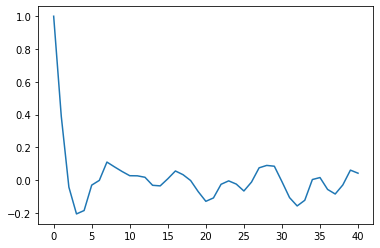

In [29]:
import matplotlib.pyplot as plt # This is the traditional way to
                                #alias the pyplot subpackage.
plt.plot(acf(postwar))

This is not such a great looking ACF plot.  It is hard to make out the important lag-1 and lag-2 correlation coefficients, and there are no confidence interval lines.  For this we can use *statsmodels* `plot_acf` function.

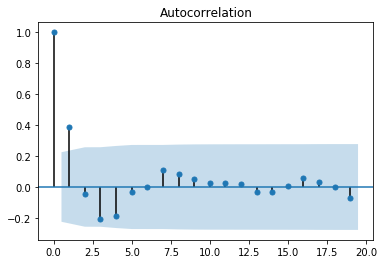

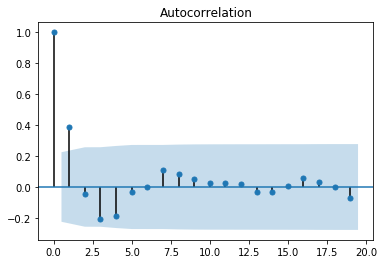

In [30]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(postwar)

This plot is much earier to read.  We get confidence interval lines, and we can more easily read the off coefficients.

But there is some goofy feature or bug where the ACF gets displayed twice (one output is by the `plot_acf` function, then the figure that is returned is plotted again.  To suppress this, you can put a semicolon at then end.

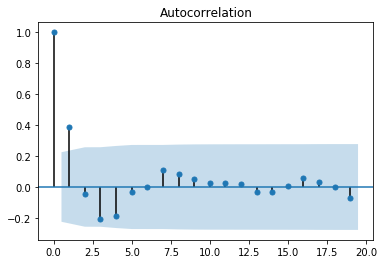

In [31]:
plot_acf(postwar);

Only the lag-1 coefficient is statistically significant with 95% confidence, but the lag-3 and lag-4 coefficients also come close.  There also appears to be some vaguely sinusoidal behavior in the ACF coefficients.

Let's also look at the PACF coefficents.

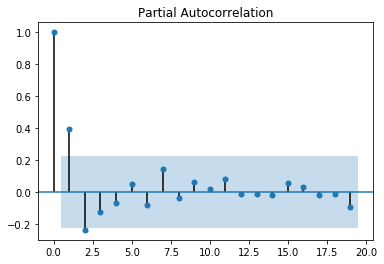

In [32]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(postwar);

Given a high lag-1 ACF but nearly zero lag-2 ACF coefficient, it makes sense that the lag-2 PACF coefficient is negative (perhaps even statistically signifcantly so).

Looking at our ACF and PACF plots, we probably would want to try an MA(1) model as well as AR(1) and AR(2) models.

How to we fit MA and AR models in Python?

In [33]:
from statsmodels.tsa.arima_model import ARIMA
# Let's set up, fit and print out results for an MA(1) model.
ARIMA(postwar, order=(0,0,1)).fit().summary()

/Users/Seiko/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            Value Value   No. Observations:                   76
Model:                     ARMA(0, 1)   Log Likelihood                 105.729
Method:                       css-mle   S.D. of innovations              0.060
Date:                Tue, 09 Feb 2021   AIC                           -205.459
Time:                        16:09:40   BIC                           -198.466
Sample:                    12-31-1945   HQIC                          -202.664
                         - 12-31-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0241      0.010      2.404      0.016       0.004       0.044
ma.L1.Value Value     0.4594      0.106      4.318      0.000       0.251       0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.1769           +0.0000j            2.1769            0.5000
-----------------------------------------------------------------------------
"""

Python is warning us because it doesn't know what to do with our date index.  We could just ignore the warning, but let's try to explicitly set the frequency of our time series to annual, so as to avoid thus warning message.

In [34]:
postwar = postwar.asfreq("A")
postwar.head()

Date
1945-12-31    0.008502
1946-12-31   -0.094253
1947-12-31    0.083614
1948-12-31    0.072196
1949-12-31    0.224536
Freq: A-DEC, Name: Value Value, dtype: float64

In [35]:
ARIMA(postwar, order=(0,0,1)).fit().summary()
# We try again and this time no warning!

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            Value Value   No. Observations:                   76
Model:                     ARMA(0, 1)   Log Likelihood                 105.729
Method:                       css-mle   S.D. of innovations              0.060
Date:                Tue, 09 Feb 2021   AIC                           -205.459
Time:                        16:09:40   BIC                           -198.466
Sample:                    12-31-1945   HQIC                          -202.664
                         - 12-31-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0241      0.010      2.404      0.016       0.004       0.044
ma.L1.Value Value     0.4594      0.106      4.318      0.000       0.251       0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.1769           +0.0000j            2.1769            0.5000
-----------------------------------------------------------------------------
"""

The ***S.D. of innovations*** above is essentially the square root of the mean squared error (sigma^2) that would be given by R's arima function.  Here ***innovations*** is basically another time series word for the "error" or "noise" term $\epsilon_t$.

Let's now compare the MA(2) model.

In [36]:
ARIMA(postwar, order=(0,0,2)).fit().summary()  # MA(2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            Value Value   No. Observations:                   76
Model:                     ARMA(0, 2)   Log Likelihood                 105.778
Method:                       css-mle   S.D. of innovations              0.060
Date:                Tue, 09 Feb 2021   AIC                           -203.555
Time:                        16:09:41   BIC                           -194.232
Sample:                    12-31-1945   HQIC                          -199.829
                         - 12-31-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0240      0.010      2.290      0.022       0.003       0.045
ma.L1.Value Value     0.4733      0.116      4.069      0.000       0.245       0.701
ma.L2.Value Value     0.0537      0.172      0.312      0.755      -0.283       0.391
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -3.5158           +0.0000j            3.5158            0.5000
MA.2           -5.2943           +0.0000j            5.2943            0.5000
-----------------------------------------------------------------------------
"""

There is no improvement for MA(2) of the S.D. of innovations (which I will call ***RMSE*** or root mean squared error), so the addition of one more parameter actually makes the ***AIC*** (***Aikake information criterion***) and the ***BIC*** (***Bayesian information criterion***, pg. 98 of Chatfield and Xing) worse (less negative).  This is not surprising since the lag-2 ACF coefficient was close to zero and not statistically significant.

Now let's try the AR(1) and AR(2) models.

In [37]:
ARIMA(postwar, order=(1,0,0)).fit().summary()  # AR(1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            Value Value   No. Observations:                   76
Model:                     ARMA(1, 0)   Log Likelihood                 104.411
Method:                       css-mle   S.D. of innovations              0.061
Date:                Tue, 09 Feb 2021   AIC                           -202.822
Time:                        16:09:41   BIC                           -195.830
Sample:                    12-31-1945   HQIC                          -200.028
                         - 12-31-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0236      0.011      2.081      0.037       0.001       0.046
ar.L1.Value Value     0.3866      0.105      3.685      0.000       0.181       0.592
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5863           +0.0000j            2.5863            0.0000
-----------------------------------------------------------------------------
"""

In [38]:
ARIMA(postwar, order=(2,0,0)).fit().summary()  # AR(2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            Value Value   No. Observations:                   76
Model:                     ARMA(2, 0)   Log Likelihood                 106.526
Method:                       css-mle   S.D. of innovations              0.059
Date:                Tue, 09 Feb 2021   AIC                           -205.051
Time:                        16:09:41   BIC                           -195.728
Sample:                    12-31-1945   HQIC                          -201.325
                         - 12-31-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0242      0.009      2.680      0.007       0.006       0.042
ar.L1.Value Value     0.4799      0.112      4.303      0.000       0.261       0.699
ar.L2.Value Value    -0.2363      0.113     -2.089      0.037      -0.458      -0.015
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0155           -1.7891j            2.0572           -0.1678
AR.2            1.0155           +1.7891j            2.0572            0.1678
-----------------------------------------------------------------------------
"""

The AR(1) peforms worse in terms of RMSE than the MA(1) or MA(2) models.  This is not surprising since an AR(1) with an approximate 0.4 lag-1 correlation coefficient will give an approximate 0.16 lag-2 correlation coefficient, whereas the actual sample lag-2 corrlation coefficient is approximately zero.

On the other hand, the AR(2) has a better RMSE than either the AR(1) or the MA(1) or MA(2) models.  This also is not surprsing because the PACF had a statistically significant lag-2 coefficient.

But althought the AR(2) has a better RMSE than MA(1), we should also compare their AICs and BICs since MA(1) has less parameters.  And actually the MA(1) model has better (more negative) AIC's and BIC's, so on that basis we would choose MA(1) over AR(2).

Finally, for completeness let's check the ARMA(1,1) model, which was our favorite model last time.

In [39]:
ARIMA(postwar, order=(1,0,1)).fit().summary()  # ARMA(1,1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            Value Value   No. Observations:                   76
Model:                     ARMA(1, 1)   Log Likelihood                 105.759
Method:                       css-mle   S.D. of innovations              0.060
Date:                Tue, 09 Feb 2021   AIC                           -203.519
Time:                        16:09:41   BIC                           -194.196
Sample:                    12-31-1945   HQIC                          -199.793
                         - 12-31-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0240      0.010      2.328      0.020       0.004       0.044
ar.L1.Value Value     0.0698      0.273      0.256      0.798      -0.465       0.605
ma.L1.Value Value     0.3992      0.260      1.535      0.125      -0.111       0.909
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           14.3325           +0.0000j           14.3325            0.0000
MA.1           -2.5049           +0.0000j            2.5049            0.5000
-----------------------------------------------------------------------------
"""

This is no improvement in RMSE compared to MA(1) and is worse than AR(2), and is worse than both also in terms of the AIC and BIC.  This again is not surprising since the ACF of an ARMA(1,1) is exponentially decaying, whereas we want the ACF to drop to zero, and maybe even be negative for lags 3 and 4.

# The backshift operator

It is convenient to introduce the ***backshift operator B***, defined as
$$BX_t = X_{t-1}.$$
Sometimes this is also called the ***lag operator*** and is denoted ***L***.

It is best to think of the backshift operator as acting on the entire series.

We can apply the backshift operator successively, for example
$$B^2 X_t = B(BX_t)  =BX_{t-1} = X_{t-2}$$
and more generally
$$B^k X_t = X_{t-k}.$$

The backshift operator has an inverse $B^{-1}$ defined as
$$B^{-1} X_t = X_{t+1}.$$

The differencing operator $\nabla$ can be written in terms of the backshift operator as $1-B$:
$$\nabla X_t = X_t - X_{t-1} = X_t - BX_t = (1-B)X_t.$$



# A closer look at the AR(1) process.

The AR(1) process is defined as
$$X_t = c + \alpha X_{t-1} + \epsilon_t.$$

Since the constant $c$ does not effect variance, covariance or correlations, without loss of generality let's assume that $c=0$.  Then we can have
$$X_t = \alpha X_{t-1} + \epsilon_t$$
or in terms of the backshift operator
$$(1 - \alpha B) X_t = \epsilon_t.$$

If $|\alpha| < 1$, then the operator $1 - \alpha B$ has an inverse given by
$$1 + \alpha B + \alpha^2 B^2 + \cdots.$$

Therefore we can rewrite the AR(1) process as
\begin{align}
X_t &= (1- \alpha B)^{-1} \epsilon_t\\
&= (1 + \alpha B + \alpha^2 B^2 + \cdots) \epsilon_t\\
&= \epsilon_t + \alpha B \epsilon_t + \alpha^2 B^2 \epsilon_t + \cdots\\
&= \epsilon_t + \alpha \epsilon_{t-1} + \alpha^2 \epsilon_{t-2} + \cdots
\end{align}
as we discussed previously.  So we can think on an AR(1) process as an **M($\infty$) process** with exponentially decreasing coefficients.

# A closer look at the AR(2) process

When we introduced the general MA($q$) process, we had an explicit formula for the ACF function:
$$\rho(k) = \begin{cases}
\frac{\beta_0 \beta_k + \beta_1 \beta_{k+1} + \cdots + \beta_{q-k} \beta_q}{\beta_0^2 + \beta_1^2 + \cdots + \beta_q^2} & \text{if } 0 \leq k \leq q, \\
0 &  \text{if } k > q.\\
\end{cases}$$
What about the general AR($p$) process?  Or the general ARMA($p,q$)?  Let's start with the AR(2) process,
$$X_t = c + \alpha_1 X_{t-1} + \alpha_2 X_{t-2} + \epsilon_t.$$

Since the constant $c$ does not affect the correlations, without loss of generality we can assume that $c=0$ and write
$$X_t = \alpha_1 X_{t-1} + \alpha_2 X_{t-2} + \epsilon_t.$$

Using the backshift operator we can rewrite the AR(2) process as:
$$X_t = \alpha_1 BX_t + \alpha_2 B^2X_t + \epsilon_t.$$

We can rewrite this as
$$(1 - \alpha_1 B - \alpha_2 B^2) X_t = \epsilon_t,$$
or
$$X_t = (1 - \alpha_1 B - \alpha_2 B^2)^{-1} \epsilon_t.$$

Let $\pi_1, \pi_2$ be the **roots** of the quadratic equation $y^2 - \alpha_1 y -\alpha_2$.  Then $1 - \alpha_1 B - \alpha_2 B^2$ factors as $(1 - \pi_1 B)(1 - \pi_2 B)$.

Then we get
$$X_t = (1 - \pi_1 B)^{-1} (1 - \pi_2 B)^{-1} \epsilon_t.$$

This only makes sense if $|\pi_1|$ and $|\pi_2|$ are less than 1, i.e. within the complex unit circle, and this is a necessary and sufficient condition that the AR(2) process is stationary.

Note that the condition that the roots of $y^2 - \alpha_1 y -\alpha_2$ lie within the unit circle is equivalent to the condition that the roots $1 - \alpha_1 z - \alpha_2 z^2$ lie ***outside*** the unit circle.

In other words, if we treat the operator polynomial $1 - \alpha_1 B - \alpha_2 B^2$ as a usual polynomial, then the **AR(2) process is stationary if and only if the roots of $1 - \alpha_1 B - \alpha_2 B^2$ like outside the complex unit circle.**

If the AR(2) process is indeed stationary, then there are two kinds of behavior that are possible:  If the two roots are real, then the ACF will decay exponentially to zero (similarly to the AR(1) case).  But if the two roots are complex conjugates, then the ACF will have sinusoidal decay.  See Chatfield and Xing pg. 57-59 for more information.

Let's consider again the equation
$$X_t = \alpha_1 X_{t-1} + \alpha_2 X_{t-2} + \epsilon_t.$$
If we know $X_t$ to be stationary, then we can take covariances of the above equation with $X_{t-1}$ to get
$$\gamma(1) = \alpha_1 \gamma(0) + \alpha_2 \gamma(1)$$
since $\gamma(1) = \gamma(-1)$.
We can solve for lag-1 covariance $\gamma(1)$ to get
$$\gamma(1) = \frac{\alpha_1}{1-\alpha_2}\gamma(0)$$
and if we divide by variance $\gamma(0)$ we get lag-1 correlation
$$\rho(1) = \frac{\alpha_1}{1 - \alpha_2}.$$

We can also take covariance with $X_{t-k}$ and then divide by variance $\gamma(0)$ to get the lag-$k$ correlation coefficient
$$\rho(k) = \alpha_1 \rho(k-1) + \alpha_2 \rho(k-2).$$

From this we can recursively calculate further correlation coefficients, e.g.
$$\rho(2) = \frac{\alpha_1^2}{1 - \alpha_2} + \alpha_2.$$

**Example.**  Let's consider the AR(2) model that we fit above:
$$X_t = 0.0247 + 0.4824 X_{t-1} - 0.2329 X_{t-2} + \epsilon_t.$$

The equation $y^2 - 0.4824 y + 0.2329$ has roots
$$\pi_{1,2} = \frac{0.4824 \pm \sqrt{.4824^2 - 4 \times 0.2329}}{2} = 0.2412 \pm 0.8360 i$$
which are complex conjugates lying within the unit circle, so we should get sinusoidally decaying ACF coefficients.

Let's also calculate the first few ACF coefficients of the fitted AR(2) model.
$$\rho(1) = \frac{0.4824}{1 + 0.2329} = 0.3913,$$ which closely mathces the sample lag-1 coefficient 0.3951.
$$\rho(2) = 0.4824 \times 0.3913 - 0.2329 = -0.0441,$$ which is close to the sample lag-2 coefficient -0.0381.
$$\rho(3) = 0.4824 \times -0.0441 - 0.2329 \times 0.3913 = -0.1124,$$
which is not too far from -0.2048.
Of course, as we go further out, the fitted model ACF will diverge from the sample ACF.


# The general AR($p$) process

Consider the AR($p$) process
$$X_t = \alpha_1 X_{t-1} + \alpha_2 X_{t-2} + \cdots + \alpha_p X_{t-p} + \epsilon_t$$
which we can write as
$$\phi(B) X_t = \epsilon_t$$
where
$$\phi(B) = 1 - \alpha_1 B - \alpha_2 B^2 - \cdots - \alpha_p B^p.$$
**If the roots of the polynomial $\phi(B)$ all lie outside the unit circle, then the AR($p$) process is stationary.**

Moreover, we can write the AR($p$) process as
$$X_t = \phi(B)^{-1} \epsilon_t$$
which takes the form of an MA($\infty$) process.

# The general ARMA($p,q$) process

Consider the ARMA($p,q$) process
$$X_t = \alpha_1 X_{t-1} + \cdots + \alpha_p X_{t-p} + \epsilon_t + \beta_1 \epsilon_{t-1}+ \cdots + \beta_q \epsilon_{t-q}$$
which we can write as
$$\phi(B) X_t = \theta(B) \epsilon_t$$
where
$$\phi(B) = 1 - \alpha_1 B - \alpha_2 B^2 - \cdots - \alpha_p B^p$$
and
$$\theta(B) = 1 + \beta_1 B + \beta_2 B^2 + \cdots + \beta_q B^q$$
**If the roots of the polynomial $\phi(B)$ all lie outside the unit circle, then the ARMA($p,q$) process is stationary.**

Moreover, we can write the ARMA($p,q$) process as
$$X_t = \frac{\theta(B)}{\phi(B)} \epsilon_t$$
which takes the form of an MA($\infty$) process.

# The ARIMA($p,d,q$) process

As we have seen, we often have to take differences
$$\nabla X_t = (1-B) X_t = X_t - X_{t-1}$$
to tranform a time series such as a random walk into a stationary series.

In rare cases, we may have to take differences more than once, such as second order differencing:
$$\nabla^2 X_t = (1-B)^2 X_t = X_t - 2 X_{t-1} + X_{t-2}.$$

More generally, if we do $d$-order differencing, we hope to arrive at a stationary series
$$W(t) = (1-B)^d X_t$$
which we can model as an ARMA($p,q$) process
$$ \phi(B) W(t) = \theta(B)\epsilon_t.$$

Therefore we get
$$(1-B)^d \phi(B) X_t = \theta(B) \epsilon_t.$$

We call such an $X_t$ an **integated ARMA** or **ARIMA** process of **order $(p,d,q)$**.